# Analysis of MTA Permanent Art Collection

## Introduction
The MTA Permanent Art Program features hundreds of artworks across New York City subway stations.  
In this analysis, I will clean the dataset and explore three main questions:  
1. Which subway lines have the most artworks?  
2. Which artists appear most often?  
3. What materials are most commonly used by decade?

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import unicodedata

url = "https://data.ny.gov/resource/4y8j-9pkd.csv"

# Load dataset
df = pd.read_csv(url)
df.head()

,agency,station_name,line,artist,art_title,art_date,art_material,art_description,art_image_link
0,NYCT,Clark St,"2,3",Ray Ring,Clark Street Passage,1987,Terrazzo floor tile,The first model that Brooklyn-born artist Ray ...,https://new.mta.info/agency/arts-design/collec...
1,NYCT,125 St,"4,5,6",Houston Conwill,The Open Secret,1986,Bronze - polychromed,"The Open Secret, in the 125th Street and Lexin...",https://new.mta.info/agency/arts-design/collec...
2,NYCT,Astor Pl,6,Milton Glaser,Untitled,1986,Porcelain enamel murals,"Milton Glaser, best known for his work in grap...",https://new.mta.info/agency/arts-design/collec...
3,NYCT,Kings Hwy,"B,Q",Rhoda Andors,Kings Highway Hieroglyphs,1987,Porcelain Enamel Murals on Steel,The artist discusses her work: ÒIf public art...,https://new.mta.info/agency/arts-design/collec...
4,NYCT,Newkirk Av,"B,Q",David Wilson,Transit Skylight,1988,Zinc-glazed Apolycarbonate skylight,"The artist recalls, ÒAbout the same time that ...",https://new.mta.info/agency/arts-design/collec...


## Data Cleaning
I started by previewing the dataset to understand its structure. To simplify the analysis, I :

>- Dropped columns that were not needed (`Art Title`, `Art Description`, `Art Image Link`)

>- Removed duplicates based on Station Name

>- Filtered out non-NYCT agencies (Metro-North, LIRR, B&T)

>- Standardized text columns to lowercase and removed extra spaces

In [30]:
# Drop unwanted columns and remove duplicates/NaNs
df = df.drop(columns=["art_title", "art_description", "art_image_link"])
df = df.dropna()
df = df.drop_duplicates(subset=["station_name"])

# Remove Metro-North and LIRR entries
df = df[~df['agency'].str.contains('Metro North|LIRR|B&T', case=False)]

# Apply strip + lowercase to all object (string) columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip().str.lower()

df.head()

,agency,station_name,line,artist,art_date,art_material
0,nyct,clark st,"2,3",ray ring,1987,terrazzo floor tile
1,nyct,125 st,"4,5,6",houston conwill,1986,bronze - polychromed
2,nyct,astor pl,6,milton glaser,1986,porcelain enamel murals
3,nyct,kings hwy,"b,q",rhoda andors,1987,porcelain enamel murals on steel
4,nyct,newkirk av,"b,q",david wilson,1988,zinc-glazed apolycarbonate skylight


## Q1. Which subway lines have the most artworks?  

Some artworks appear on multiple lines via shared stations. To count them correctly, I split the `Line` column and expanded the rows so that each line is represented individually. 

In [31]:
df = df.assign(Line=df['line'].str.split(',')).explode('line')
df['line'] = df['line'].str.strip()
df = df.dropna(subset=["line"])

df.head()

,agency,station_name,line,artist,art_date,art_material,Line
0,nyct,clark st,"2,3",ray ring,1987,terrazzo floor tile,"[2, 3]"
1,nyct,125 st,"4,5,6",houston conwill,1986,bronze - polychromed,"[4, 5, 6]"
2,nyct,astor pl,6,milton glaser,1986,porcelain enamel murals,[6]
3,nyct,kings hwy,"b,q",rhoda andors,1987,porcelain enamel murals on steel,"[b, q]"
4,nyct,newkirk av,"b,q",david wilson,1988,zinc-glazed apolycarbonate skylight,"[b, q]"


Next, I counted artworks per line and plotted the top 10 lines.

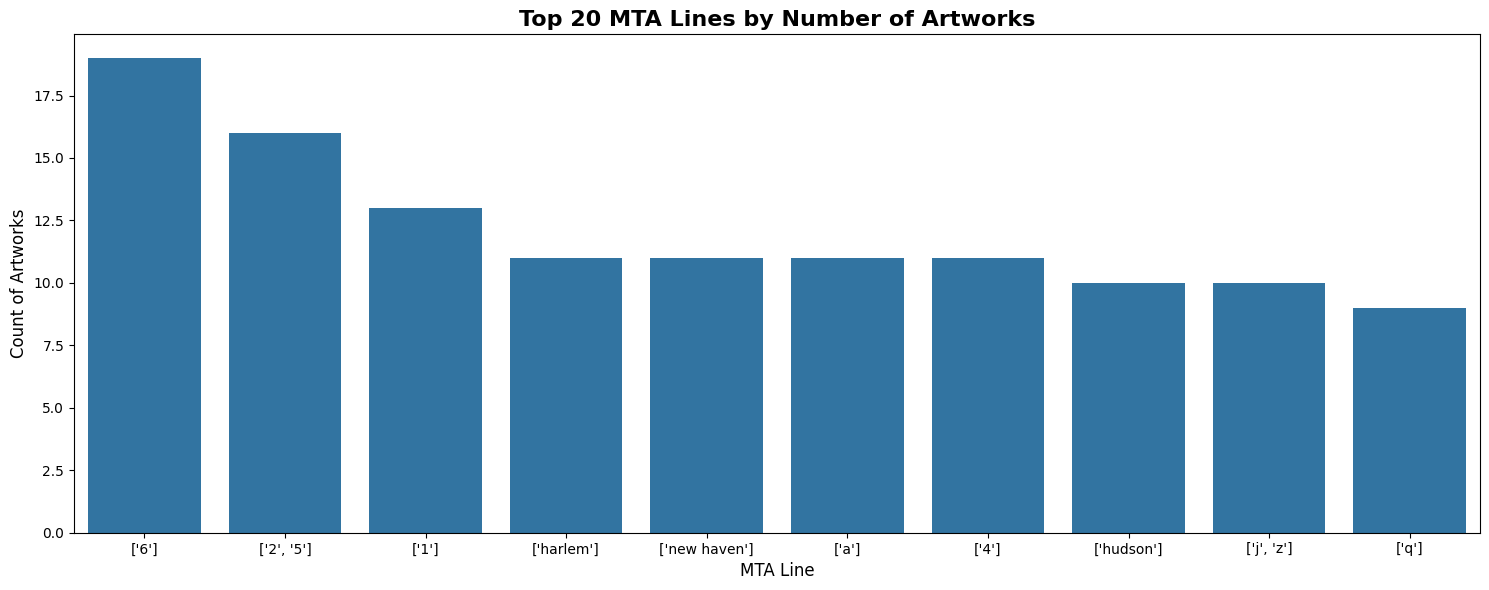

In [32]:
# Top 10 MTA lines
top10_lines = df["Line"].value_counts().head(10).index
df_top10 = df[df["Line"].isin(top10_lines)]

# Plot top 10 lines
plt.figure(figsize=(15,6))
sns.countplot(
    data=df_top10, 
    x="Line", 
    order=top10_lines
)
plt.title("Top 20 MTA Lines by Number of Artworks", fontsize=16, weight="bold")
plt.xlabel("MTA Line", fontsize=12)
plt.ylabel("Count of Artworks", fontsize=12)
plt.tight_layout()
plt.show()

### Findings:
The lines with the most artworks are **2, 5, 6, Q, and 3**. These are among the busiest subway routes, which explains the higher concentration of public art in stations along these lines. The distribution of artworks is clearly uneven, with major transfer points and high-traffic stations featuring more art.

## Q2. Which artists have the most artworks?  

To analyze contributions by artist, I cleaned the `Artist` column by normalizing special characters, splitting collaborative names, and exploding them into separate rows. 


In [33]:
# Function to clean text
def clean_text(s):
    if pd.isna(s):
        return ""
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", "ignore").decode("utf-8")
    s = re.sub(r"\s+", " ", s)
    s = s.replace("&", "and")
    return s.strip()

# Clean and explode artists
df["Artist"] = df["artist"].apply(clean_text)
df["Artist"] = df["Artist"].apply(lambda x: re.split(r"\band\b", x, flags=re.IGNORECASE))
df = df.explode("Artist")
df["Artist"] = df["Artist"].str.strip()
df = df[df["Artist"] != ""]

I then counted artworks per artist and plotted the top 10 contributors.

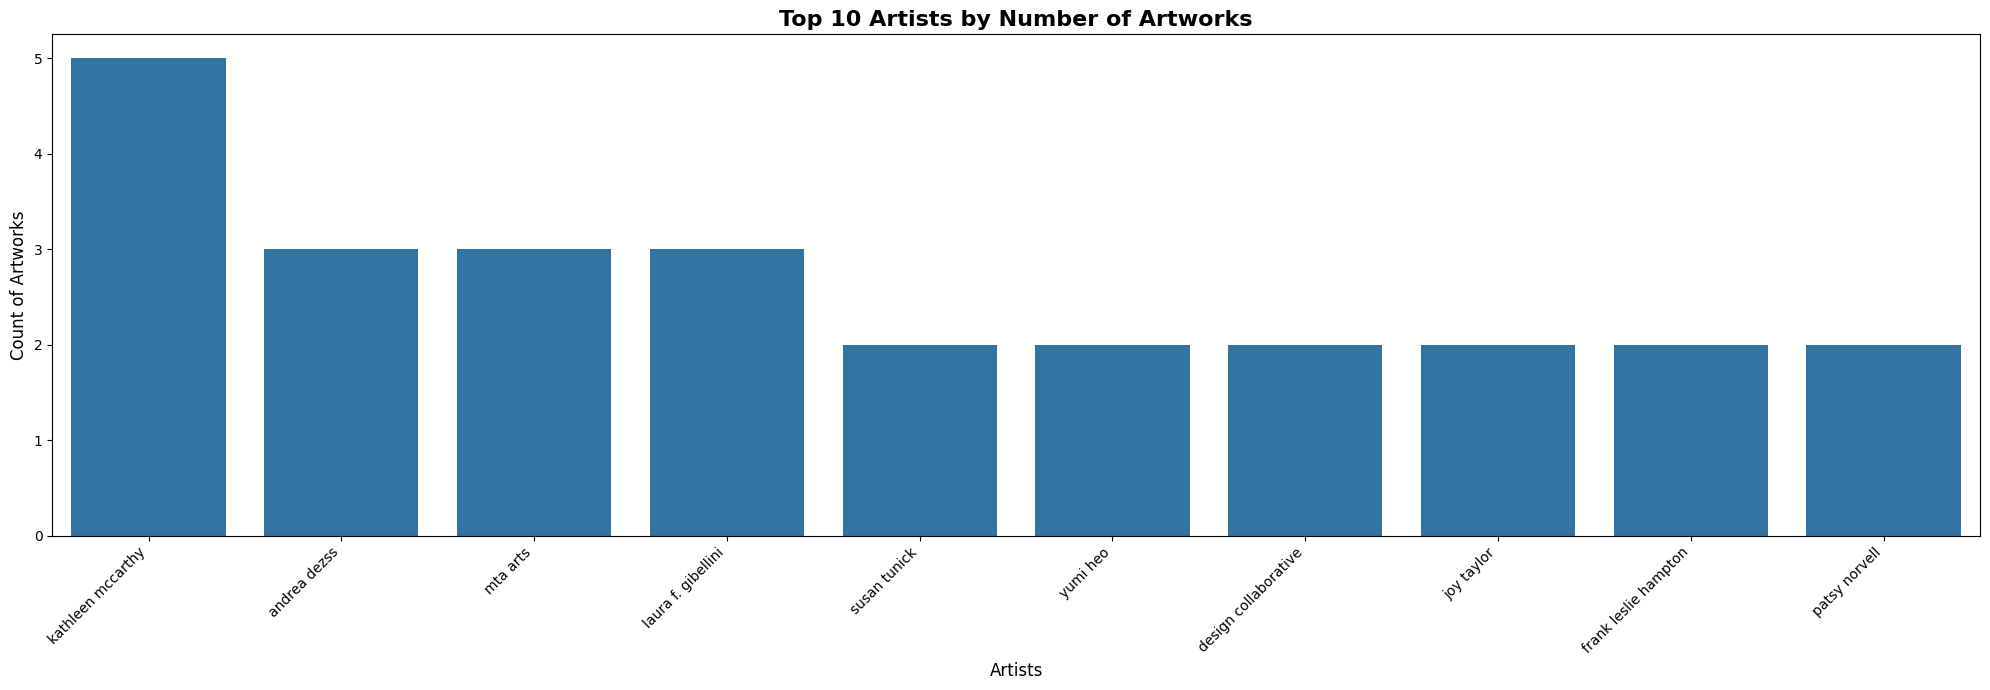

In [34]:
# Top 10 artists
top10_artists = df["Artist"].value_counts().head(10).index

plt.figure(figsize=(20,7))
sns.countplot(
    data=df[df["Artist"].isin(top10_artists)], 
    x="Artist", 
    order=top10_artists
)
plt.title("Top 10 Artists by Number of Artworks", fontsize=16, weight="bold")
plt.xlabel("Artists", fontsize=12)
plt.ylabel("Count of Artworks", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Findings:
The most frequent contributors are **Norman B Colp, Jacob Lawrence, Kathleen McCarthy, George Trakas (with di Domenico + Partners), and Michele Oka Doner**. Both individual artists and collaborative design groups have significantly shaped the subway’s artistic identity.

## Q3. What materials are most commonly used by decade?  

To explore material trends, I first cleaned and standardized the `Art Material` column. Variations like “stainless steel” and “stainless” were unified. Artworks with multiple materials were split so each material could be counted individually.


In [35]:
# Function to tidy Art Material column
def tidy_material(material_series):
    s = material_series.str.lower().str.strip()
    s = s.str.replace(r"\(.*?\)", "", regex=True)
    s = s.str.replace(r"(throughout|in passageway|on .*|in .*|with .*|etc\.)", "", regex=True)
    s = s.str.replace(r"[;/]", ",", regex=True)
    s = s.str.split(r",| and ").explode().str.strip()
    s = s[s != ""]
    standard_map = {
        "aluminum - painted": "aluminum",
        "cast aluminum": "aluminum",
        "bronze - hand forged": "bronze",
        "bronze - patinated": "bronze",
        "bronze - polychromed": "bronze",
        "bronze and steel sheet": "bronze and steel",
        "stainless": "steel",
        "stainless steel": "steel",
        "steel with galvinized steel cable": "steel",
        "cast concrete": "concrete",
        "concrete - jesmonite castings": "concrete",
        "faceted glass": "glass",
        "fused glass": "glass",
        "glass mosaic": "glass",
        "laminated glass": "glass",
        "glass blocks": "glass",
        "glass block": "glass",
        "glass, ceramic mosaic": "glass and ceramic",
        "glass and ceramic mosaic": "glass and ceramic",
        "ceramic tile, glass mosaic": "ceramic and glass",
        "ceramic tile, glass mosaic": "ceramic and glass",
        "porcelain enamel murals": "porcelain",
        "porcelain enamel murals on steel": "porcelain and steel",
        "porcelain enamel on steel": "porcelain and steel",
        "porcela": "porcelain enamel",
        "porcelain enamel?": "porcelain enamel",
        "wrought ir": "iron",
        "wrought iron": "iron",
        "stone - etched granite": "stone",
        "stone - absolute black granite": "stone",
        "marble and stone mosaic": "marble and stone",
        "marble mosaic walls": "marble",
        "terracotta": "ceramic",
        "terrazzo floor tile": "terrazzo",
        "zinc-glazed apolycarbonate skylight": "zinc-glass",
        "red clay": "clay",
        "glazes": "glaze",
        "mirrors": "mirror",
        "lighting elements": "lighting",
        "electronic light controllers": "lighting",
    }
    return s.replace(standard_map).reset_index(drop=True)

# Apply tidy_material
df = df.assign(**{"art_material": tidy_material(df["art_material"])})
df['Art Material'] = df['art_material'].str.strip().str.lower()

I converted the `Art Date` to numeric values and grouped artworks by decade. I then counted how often each material was used per decade, ranked the materials by frequency, and kept the top five materials for each decade to highlight the most common choices over time.

In [36]:
# Convert Art Date to decade
df["Art Date"] = pd.to_numeric(df["art_date"], errors="coerce")
df = df.dropna(subset=["Art Date"])
df["Decade"] = (df["Art Date"] // 10 * 10).astype(int)

# Count materials per decade
material_counts = (
    df.groupby(["Decade", "Art Material"])
    .size()
    .reset_index(name="Count")
)

# Rank materials per decade
material_counts["Rank"] = material_counts.groupby("Decade")["Count"].rank(method="dense", ascending=False).astype(int)

# Keep only top 5 materials per decade
top_materials = material_counts[material_counts["Rank"] <= 5]

In [37]:
# Pivot top materials by rank
pivot_table = top_materials.pivot_table(
    index="Decade",
    columns="Rank",
    values="Art Material",
    aggfunc="first"
)

# Rename columns
pivot_table.columns = [f"Top {col}" for col in pivot_table.columns]

# Display
pivot_table.reset_index()

,Decade,Top 1,Top 2,Top 3,Top 4,Top 5
0,1980,bronze,ceramic tile,NaN,NaN,NaN
1,1990,glass,ceramic mosaic,steel,bronze,porcelain enamel
2,2000,glass,bronze,ceramic tile,marble,ceramic
3,2010,glass,steel,aluminum,fiberglass,ceramic
4,2020,glass,painted stainless steel,ceramic mosaic,NaN,NaN


### Findings:
The table below shows the five most commonly used materials for MTA artworks in each decade.

>* 1980s: Bronze, porcelain enamel, and zinc-glass were the most common materials.

>* 1990s: Porcelain enamel, ceramic tiles, and steel dominated.

>* 2000s: Glass and ceramic mosaics became increasingly popular alongside steel and porcelain enamel.

>* 2010s: Glass, safety glass, stone, and mirror were frequently used, reflecting more modern and durable choices.

>* 2020s: Glass and faceted glass complex lead, with occasional bronze, showing a shift toward contemporary, visually transparent materials.

This shows a clear evolution in material preferences, moving from traditional metals and porcelain to modern glass-based and composite materials over time.